<a href="https://colab.research.google.com/github/rajeev-chaudhary/Data-Engineering-projects/blob/main/Netflix_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Netflix Movies & TV Shows Analysis

In [1]:
!pip install kagglehub pandas matplotlib seaborn plotly --quiet

import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


📥 Step 1 — Download Dataset via KaggleHub

In [2]:
# Download Netflix dataset
path = kagglehub.dataset_download("shivamb/netflix-shows")
print("Dataset path:", path)

file_path = path + "/netflix_titles.csv"
df = pd.read_csv(file_path, encoding='latin1')
df.head(3)


Using Colab cache for faster access to the 'netflix-shows' dataset.
Dataset path: /kaggle/input/netflix-shows


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


🧹 Step 2 — Data Cleaning & Feature Engineering

In [3]:
# Standardize columns
df.columns = df.columns.str.strip().str.replace(' ', '_')

# Convert dates
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
df['release_year'] = df['release_year'].astype(int)

# Extract year and month added
df['added_year'] = df['date_added'].dt.year
df['added_month'] = df['date_added'].dt.month

# Fill missing values
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Not Rated')

# Quick overview
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8807 non-null   object        
 1   type          8807 non-null   object        
 2   title         8807 non-null   object        
 3   director      6173 non-null   object        
 4   cast          7982 non-null   object        
 5   country       8807 non-null   object        
 6   date_added    8709 non-null   datetime64[ns]
 7   release_year  8807 non-null   int64         
 8   rating        8807 non-null   object        
 9   duration      8804 non-null   object        
 10  listed_in     8807 non-null   object        
 11  description   8807 non-null   object        
 12  added_year    8709 non-null   float64       
 13  added_month   8709 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 963.4+ KB


📊 Step 3 — Exploratory Data Analysis (EDA)

/tmp/ipython-input-3701067332.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, palette='coolwarm')


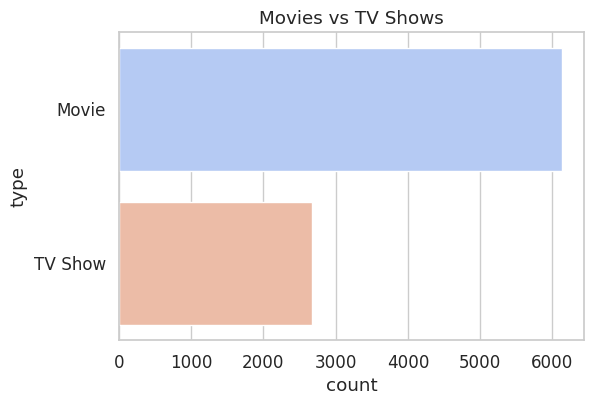

In [4]:
'''1️⃣ Content Type Distribution'''
plt.figure(figsize=(6,4))
sns.countplot(y='type', data=df, palette='coolwarm')
plt.title("Movies vs TV Shows")
plt.show()


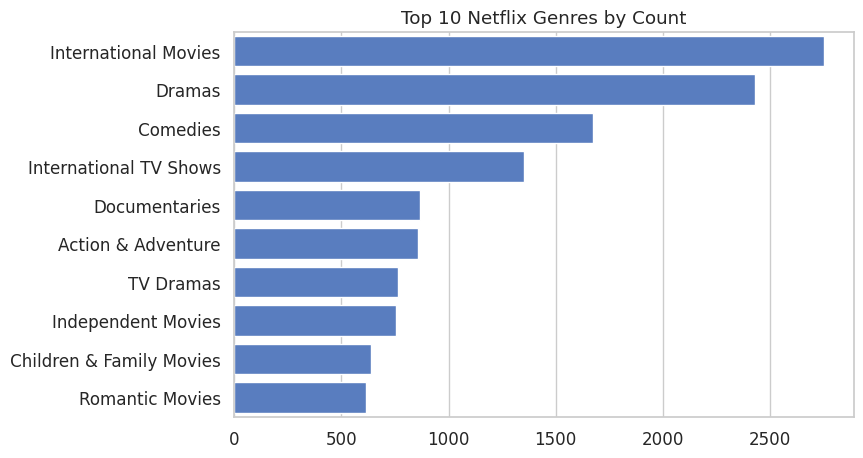

In [5]:
'''2️⃣ Top Genres (based on content count)'''
# Split multi-genres
from collections import Counter
genres = df['listed_in'].dropna().str.split(', ')
genre_counts = Counter([g for sublist in genres for g in sublist])
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(8,5))
sns.barplot(x=list(top_genres.values()), y=list(top_genres.keys()))
plt.title("Top 10 Netflix Genres by Count")
plt.show()


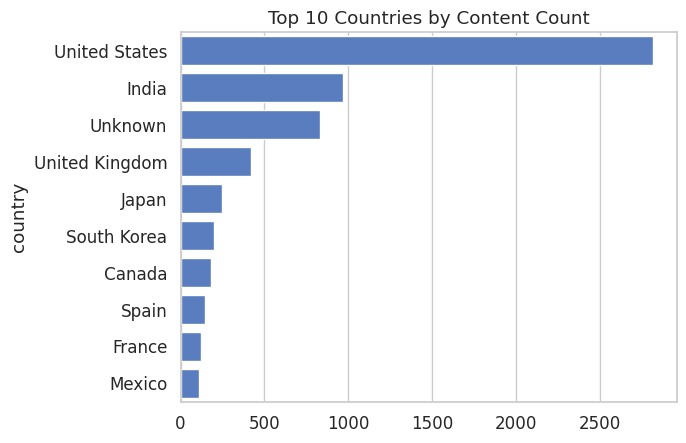

In [6]:
''' 3️⃣ Country-wise Content Count'''
top_countries = df['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title("Top 10 Countries by Content Count")
plt.show()


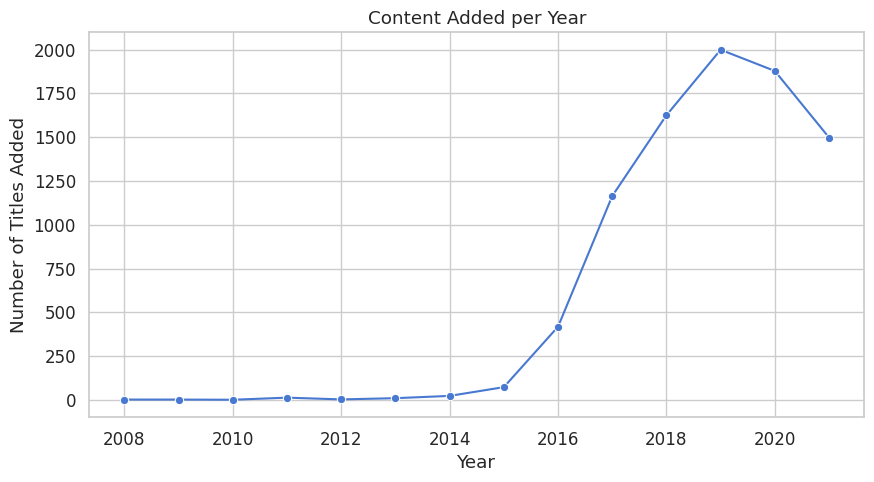

In [7]:
'''4️⃣ Year-wise Added Content Trend'''
added_trend = df['added_year'].value_counts().sort_index()
plt.figure(figsize=(10,5))
sns.lineplot(x=added_trend.index, y=added_trend.values, marker='o')
plt.title("Content Added per Year")
plt.xlabel("Year")
plt.ylabel("Number of Titles Added")
plt.show()


📈 Step 4 — Profitability/Popularity Proxy (Optional)

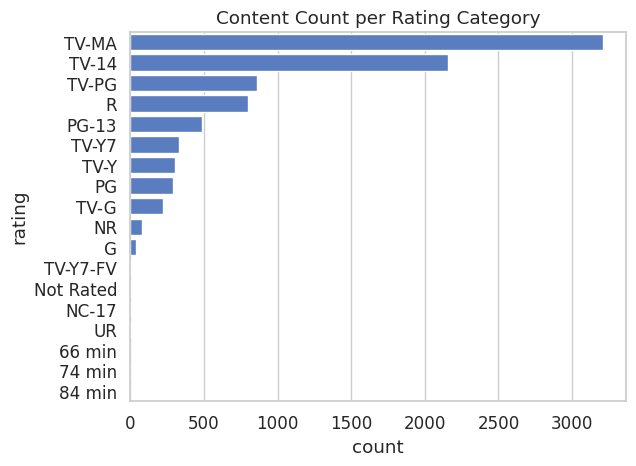

In [8]:
# Example: Count shows per rating category
sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index)
plt.title("Content Count per Rating Category")
plt.show()


🌐 Step 5 — Interactive Plot (Optional Plotly)

In [9]:
fig = px.scatter(df, x='release_year', y='added_year', color='type',
                 hover_data=['title','country','rating'],
                 title="Netflix Content Release vs Added Year")
fig.show()


Recommendation System / Rating Prediction

In [10]:
'''Step 1 — Preprocessing'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Fill missing descriptions
df['description'] = df['description'].fillna('')

# Combine features for content similarity
df['content_features'] = df['listed_in'] + " " + df['description']
df['content_features'] = df['content_features'].fillna('')


In [11]:
''' Step 2 — TF-IDF Vectorization'''
# Convert text to TF-IDF features
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['content_features'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Reset index to match titles
df = df.reset_index()
indices = pd.Series(df.index, index=df['title']).drop_duplicates()


In [12]:
'''Step 3 — Recommendation Function'''
def get_recommendations(title, num=5):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:num+1]  # exclude itself
    movie_indices = [i[0] for i in sim_scores]
    return df[['title','type','listed_in','release_year']].iloc[movie_indices]

# Example
get_recommendations("Stranger Things", 5)


,title,type,listed_in,release_year
4733,Rowdy Rathore,Movie,"Action & Adventure, Comedies, International Mo...",2012
3986,The OA,TV Show,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",2019
1487,Sakho & Mangane,TV Show,"Crime TV Shows, International TV Shows, TV Dramas",2019
8083,Star-Crossed,TV Show,"Romantic TV Shows, TV Dramas, TV Sci-Fi & Fantasy",2014
241,Manifest,TV Show,"TV Dramas, TV Mysteries, TV Sci-Fi & Fantasy",2021


In [13]:
'''Step 4 — Rating Prediction (Optional Regression/Classification)'''
# Duration numeric
def convert_duration(x):
    if pd.isna(x):
        return 0
    if 'Season' in x:
        return int(x.split()[0])*10  # arbitrary scale
    else:
        return int(x.split()[0])

df['duration_num'] = df['duration'].apply(convert_duration)

# One-hot encode top genres
top_genres = df['listed_in'].str.get_dummies(sep=', ')
features = pd.concat([df[['duration_num','release_year']], top_genres], axis=1)

# Encode rating labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(df['rating'].fillna('Not Rated'))


Classification Report:

              precision    recall  f1-score   support

           G       0.62      0.62      0.62         8
          NR       0.25      0.19      0.21        16
       Other       0.00      0.00      0.00         3
          PG       0.47      0.49      0.48        57
       PG-13       0.34      0.31      0.32        98
           R       0.42      0.46      0.44       160
       TV-14       0.45      0.44      0.44       432
        TV-G       0.21      0.16      0.18        44
       TV-MA       0.58      0.64      0.61       642
       TV-PG       0.30      0.24      0.26       173
        TV-Y       0.57      0.52      0.55        61
       TV-Y7       0.51      0.55      0.53        67
    TV-Y7-FV       0.00      0.00      0.00         1

    accuracy                           0.49      1762
   macro avg       0.36      0.36      0.36      1762
weighted avg       0.47      0.49      0.48      1762



/tmp/ipython-input-4042379358.py:76: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




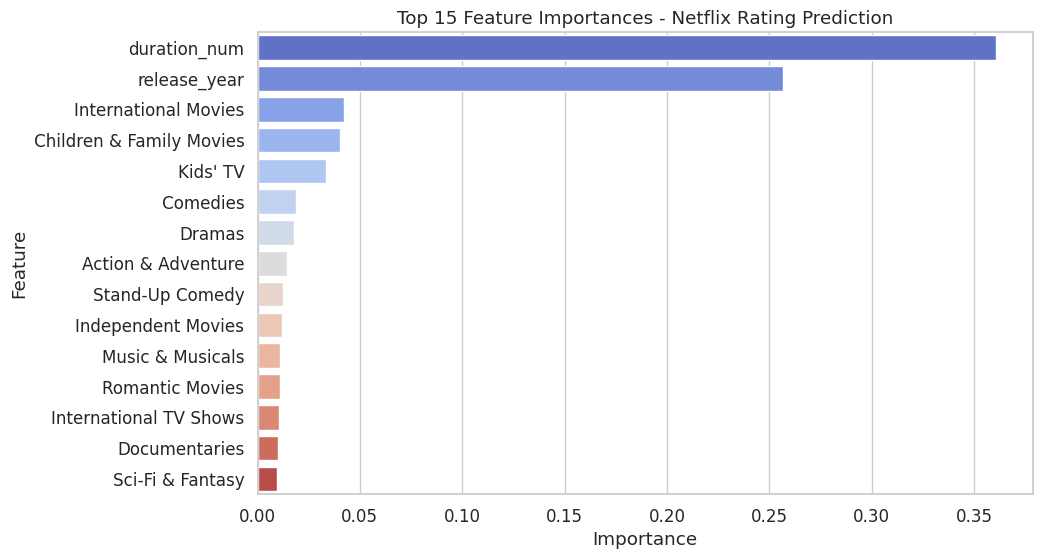

In [18]:
# -----------------------------
# Netflix ML Part — Step 5: Train-Test Split & Model
# -----------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# --- Step 1: Feature Engineering (Duration + Genres) ---
# Convert duration to numeric
def convert_duration(x):
    if pd.isna(x):
        return 0
    if 'Season' in x:
        return int(x.split()[0]) * 10  # scale seasons
    else:
        return int(x.split()[0])

df['duration_num'] = df['duration'].apply(convert_duration)
df['release_year'] = df['release_year'].fillna(0).astype(int)

# One-hot encode genres
top_genres = df['listed_in'].str.get_dummies(sep=', ')

# Combine features
features = pd.concat([df[['duration_num','release_year']], top_genres], axis=1)

# --- Step 2: Handle NaN & Rare Rating Classes ---
df['rating'] = df['rating'].fillna('Unknown')  # handle NaN
rating_counts = df['rating'].value_counts()
df['rating_clean'] = df['rating'].apply(lambda x: x if rating_counts[x] >= 5 else 'Other')

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(df['rating_clean'])

# --- Step 3: Stratified Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42, stratify=labels
)

# --- Step 4: Train RandomForestClassifier ---
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Predict & Classification Report ---
y_pred = model.predict(X_test)

# Use zero_division=0 to suppress UndefinedMetricWarning
unique_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = le.inverse_transform(unique_labels)

print("Classification Report:\n")
print(classification_report(
    y_test,
    y_pred,
    labels=unique_labels,
    target_names=target_names,
    zero_division=0
))

# --- Step 6: Feature Importance Plot (Top 15) ---
importances = model.feature_importances_
feat_names = features.columns
feat_imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df, palette='coolwarm')
plt.title("Top 15 Feature Importances - Netflix Rating Prediction")
plt.show()
